/var/folders/20/_t6_h0cx4nl1qr58y1km9l740000gn/T/ipykernel_42791/3831679166.py:39: RuntimeWarning: divide by zero encountered in log
  np.log(np.array(tuple(map(float, t_history.split(",")))) + 1)
/var/folders/20/_t6_h0cx4nl1qr58y1km9l740000gn/T/ipykernel_42791/3831679166.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(


<Axes: >

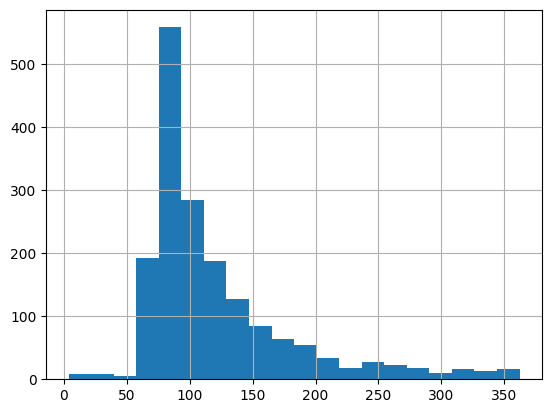

In [1]:
from itertools import accumulate
import numpy as np
import pandas as pd

BASE = 1.2


df = pd.read_csv("processed/5.csv")
df = df[df["i"] <= 4].copy()



def cum_concat(x):
    return list(accumulate(x))


t_history = df.groupby("card_id", group_keys=False)["elapsed_seconds"].apply(
    lambda x: cum_concat([[int(i)] for i in x])
)
df["t_history"] = [
    ",".join(map(str, item[:-1])) for sublist in t_history for item in sublist
]

r_history = df.groupby("card_id", group_keys=False)["rating"].apply(
    lambda x: cum_concat([[i] for i in x])
)
df["r_history"] = [
    ",".join(map(str, item[:-1])) for sublist in r_history for item in sublist
]
df = df[df["elapsed_seconds"] > 0]


def t_history_cluster(t_history):
    return ",".join(
        np.round(
            np.power(
                BASE,
                np.round(
                    np.log(np.array(tuple(map(float, t_history.split(",")))) + 1)
                    / np.log(BASE)
                ),
            )
            - 1
        )
        .astype(float)
        .astype(str)
    )


df["t_history_cluster"] = df["t_history"].apply(t_history_cluster)


def remove_outliers(group: pd.DataFrame) -> pd.DataFrame:
    Q1 = group["elapsed_seconds"].quantile(0.25)
    Q3 = group["elapsed_seconds"].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 0.5 * IQR
    group = group[group["elapsed_seconds"] <= threshold]
    return group


df = df.groupby(
    by=["r_history", "t_history_cluster"], as_index=False, group_keys=False
).apply(remove_outliers)

df[(df["r_history"] == "1") & (df["t_history"])]["elapsed_seconds"].hist(bins=20)

In [2]:
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt


DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1


def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

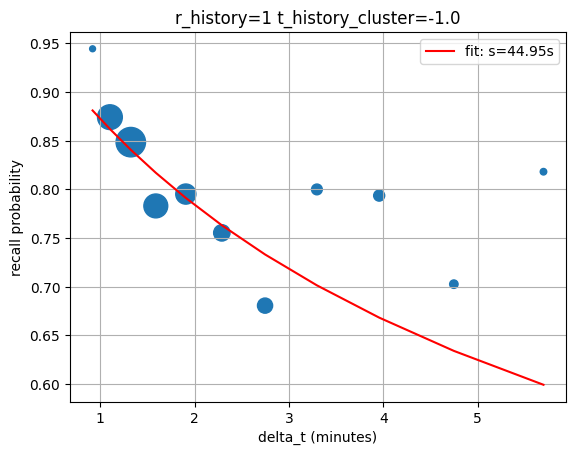

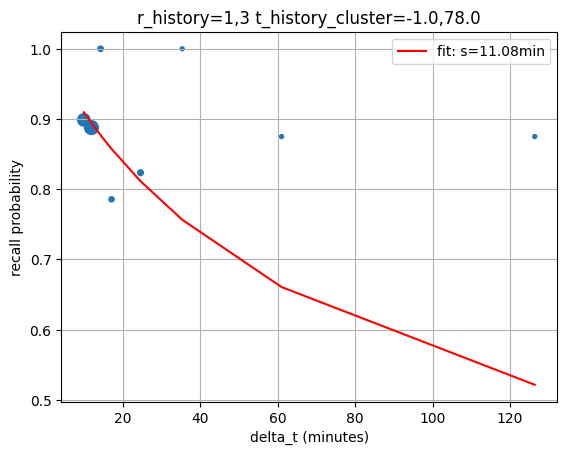

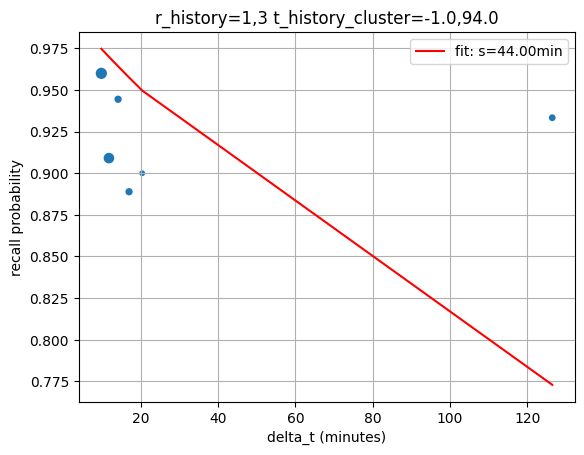

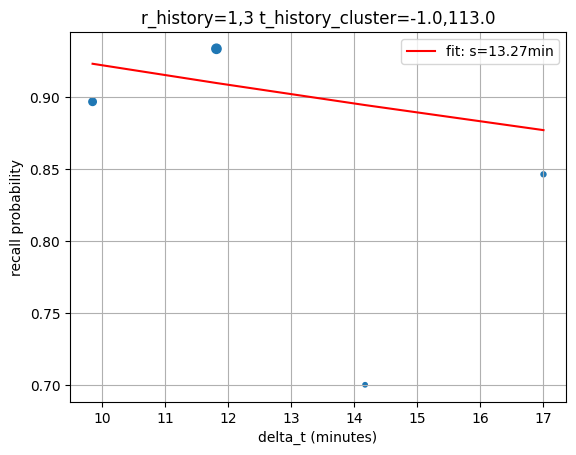

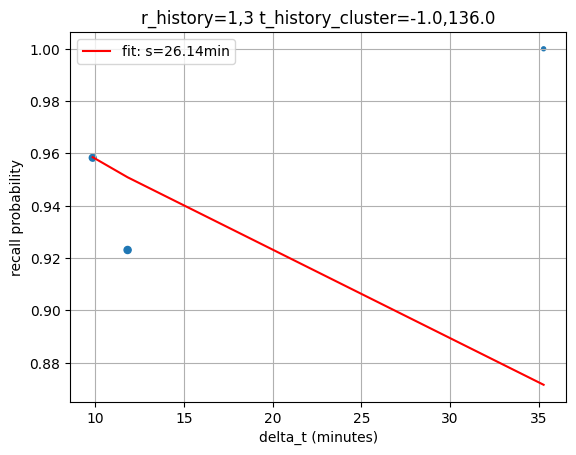

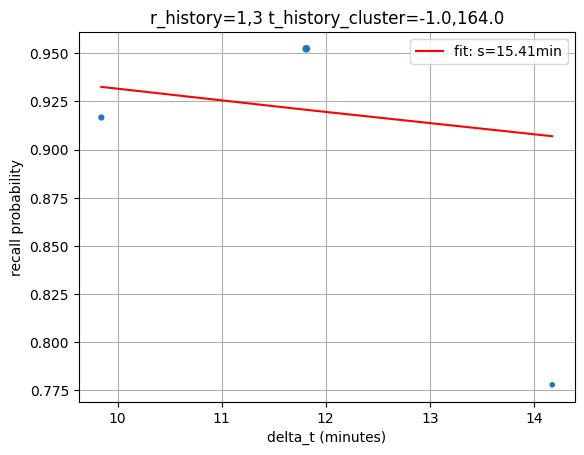

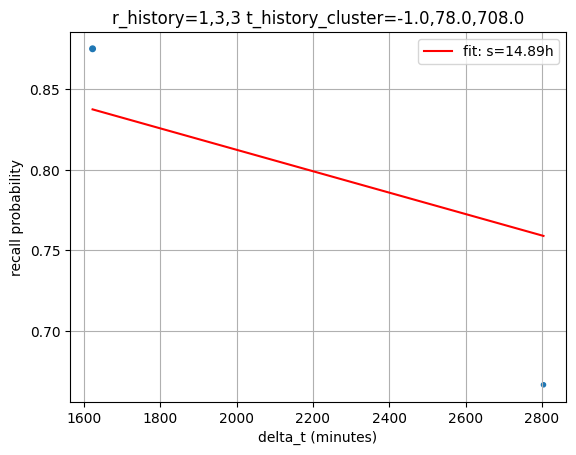

/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


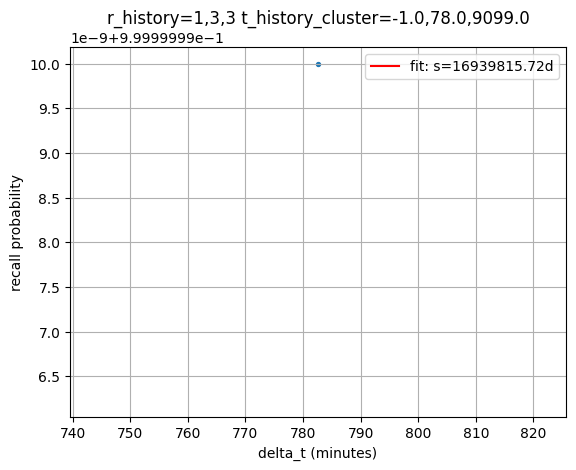

In [3]:
t_tmp = "-1.0"
for r_history in ("1", "1,3", "1,3,3"):
    for i, t_history_cluster in enumerate(
        df[
            (df["r_history"] == r_history)
            & (df["t_history_cluster"].str.startswith(t_tmp))
        ]["t_history_cluster"]
        .value_counts()
        .head(5)
        .index
    ):
        if i == 0:
            t_tmp = t_history_cluster
        df["t_bin"] = df["elapsed_seconds"].map(
            lambda x: (
                round(math.pow(BASE, math.floor(math.log(x, BASE))), 2) if x > 0 else 0
            )
        )
        df["y"] = df["rating"].map(lambda x: 1 if x > 1 else 0)
        tmp = (
            df[
                (df["r_history"] == r_history)
                & (df["t_history_cluster"] == t_history_cluster)
            ]
            .groupby("t_bin")
            .agg({"y": ["mean", "count"]})
            .reset_index()
            .copy()
        )
        tmp = tmp[(tmp["y"]["count"] >= 8)]
        if tmp.empty:
            continue
        plt.scatter(tmp["t_bin"] / 60, tmp[("y", "mean")], s=tmp[("y", "count")])
        popt, pcov = curve_fit(
            power_forgetting_curve,
            tmp["t_bin"],
            tmp[("y", "mean")],
            sigma=1 / tmp[("y", "count")],
        )
        stability = (
            f"{popt[0]:.2f}s"
            if popt[0] < 60
            else (
                f"{popt[0]/60:.2f}min"
                if popt[0] < 3600
                else (
                    f"{popt[0]/3600:.2f}h"
                    if popt[0] < 86400
                    else f"{popt[0]/86400:.2f}d"
                )
            )
        )
        plt.plot(
            tmp["t_bin"] / 60,
            power_forgetting_curve(tmp["t_bin"], *popt),
            "r-",
            label=f"fit: s={stability}",
        )
        plt.title(f"r_history={r_history} t_history_cluster={t_history_cluster}")
        plt.xlabel("delta_t (minutes)")
        plt.ylabel("recall probability")
        plt.legend()
        plt.grid()
        plt.show()